## **<div align="center">College Basketball Above or Below .500 Prediction</div>**
##### **<div align="center">Adam White, Brady Keeley</div>**
##### **<div align="center">CPSC 322, Fall 2022</div>**

### **<div align="center">Dataset Description**</div>
<div align="center">

[Data Source](https://www.kaggle.com/datasets/andrewsundberg/college-basketball-dataset) 

Format: csv

The dataset we decided to use for our project is a college basketball dataset from 2013-2019. The dataset has everywhere from basic attributes such as games won and games played, to very advanced statistics such as two-point-percentage allowed and adjusted defensive efficiency. The dataset is highly usable, with no noisy or incomplete data.

#### **Attributes**

In total, there are 24 attributes, however, we are planning on using 13 of those attributes. The attribute that we are planning on trying to predict is whether or not a team will be above a .500 win percentage. This attribute is not explicitly in the dataset, however, we are planning on calculating the win percentage for each team ourselves, then making a new column that will store a boolean value on if the team was above .500 or not. In the future, we way drop the games and games win columns altogether once we have this column, but for now, we are going to keep it in. The attributes we plan on using to calculate if a team would be above or below .500 or not are... 

1. Adjusted Offensive Efficiency (ADJOE)
1. Adjusted Defensive Efficiency (ADJDE)
1. Power Rating (BARTHAG)
1. Effective Field Goal Percentage (EFG_O)
1. Turn-Over Percentage Allowed (TOR)
1. Offensive Rebounding Rate (ORB)
1. Free Throw Rate (FTR)
1. Two-Point Percentage (2P_O)
1. Three-Point Percentage (3P_O)

For a total of 9 attributes. The rest of the attributes that we are not planning on predicting are simply there to label each of the rows. For example, we are leaving in team name and year, so we can go back and see where certain values may have come from.</div>



In [139]:
# some useful mysklearn package import statements and reloads
import importlib
import matplotlib.pyplot as plt
import copy

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

#uncomment once you paste your mypytable.py into mysklearn package
import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

# uncomment once you paste your myclassifiers.py into mysklearn package
import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyDummyClassifier, MyNaiveBayesClassifier, MyDecisionTreeClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

outfile_name = "output_data/classifier_performances.txt"
outfile = open(outfile_name, "w")
outfile.write("")
infile_name = "input_data/CBB_data_cleaned.csv"

#### **First, we need to create the appropriate table for the Input Data, and then split that data up into X and y values**

In [140]:
games_played = MyPyTable()
games_played.load_from_file(infile_name)

games_played_idx = games_played.column_names.index('G')
games_won_idx = games_played.column_names.index('W')
games_played.column_names.append("OVER_.500")

for team in games_played.data:
    win_percentage = team[games_won_idx] / team[games_played_idx]
    if win_percentage >= .500:
        team.append("TRUE")
    else:
        team.append("FALSE")
X = [value[2:12] for value in games_played.data]
y = [value[-1] for value in games_played.data]

## **Now, we need to Discretize the data so it will be usable for future classification**
To Discretize, we are going to seperate the data into two categories...
* A = Above League Average
* B = Below League Average

This is going to be done by taking the average of every attribute, and if a team is above, it will be assigned 'A'. If below, it will be assigned 'B'

In [141]:
importlib.reload(myutils)
for col_index, col_name in enumerate(games_played.column_names[2:12]):
    col_average = myutils.find_col_average(games_played, col_name)
    col_index += 2
    curr_col = games_played.get_column(col_name)
    for i, val in enumerate(curr_col):
        if val > col_average:
            games_played.data[i][col_index] = "A"
        else:
            games_played.data[i][col_index] = "B"

games_played.save_to_file("input_data/CBB_data_discretized.csv")

#### **After discretizing, we wanted to see how the classification measures out for the dataset, so we created a bar chart to show that below...**

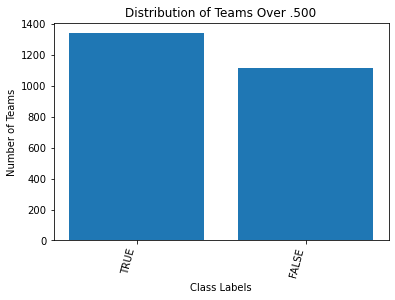

In [142]:
class_labes = myutils.get_column(games_played.data, -1)

values = [] 
counts = [] 
for value in class_labes:
    if value not in values:
        values.append(value)
        counts.append(1)
    else:
        counts[values.index(value)] += 1

myutils.bar_chart(values, counts, "Class Labels", "Number of Teams", values, "Distribution of Teams Over .500")

#### **After this, we wanted to find more distributions in our data. Total wins seemed to be an important attribute to predict on, so below are some visualizations of different distributions and correlations of the data**

## **Distribution of Total Wins**

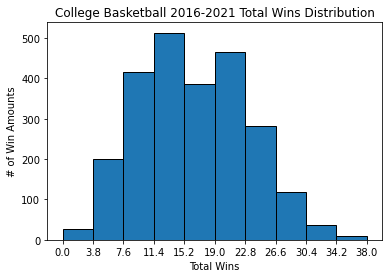

In [143]:
games_played_cleaned = MyPyTable()
games_played_cleaned.load_from_file("input_data/CBB_data_cleaned.csv")

wins_col = games_played_cleaned.get_column("W")
fig, ax = plt.subplots()
wins_freqs, wins_cutoffs, wins_artists = plt.hist(wins_col, bins=10, edgecolor="black")
ax.set_xticks(wins_cutoffs)
plt.xlabel("Total Wins")
plt.ylabel("# of Win Amounts")
plt.title("College Basketball 2016-2021 Total Wins Distribution")
plt.show()

## **Distribution of Adjusted Offensive Efficiency**

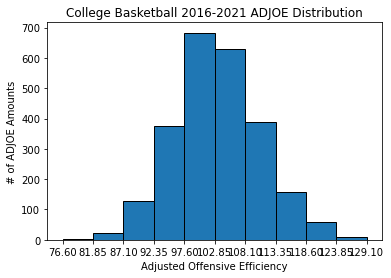

In [144]:
adjoe_col = games_played_cleaned.get_column("ADJOE")
fig, ax = plt.subplots()
adjoe_freqs, adjoe_cutoffs, adjoe_artists = plt.hist(adjoe_col, bins=10, edgecolor="black")
ax.set_xticks(adjoe_cutoffs)
plt.xlabel("Adjusted Offensive Efficiency")
plt.ylabel("# of ADJOE Amounts")
plt.title("College Basketball 2016-2021 ADJOE Distribution")
plt.show()

## **ADJOE and Total Wins Correlation**

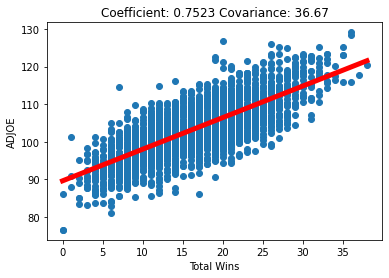

In [145]:
importlib.reload(myutils)
plt.scatter(wins_col, adjoe_col)

m, b = myutils.compute_slope_intercept(wins_col, adjoe_col)
plt.plot([min(wins_col), max(wins_col)], [m * min(wins_col) + b, m * max(wins_col) + b],
    c="red", lw=5)

r_val = myutils.compute_r(wins_col, adjoe_col)

covariance = myutils.compute_cov(wins_col, adjoe_col, r_val)
plt.title("Coefficient: {:.4f} Covariance: {:.2f}".format(r_val, covariance))
plt.ylabel("ADJOE")
plt.xlabel("Total Wins")
plt.show()

## **Turnover Allowed Distribution**

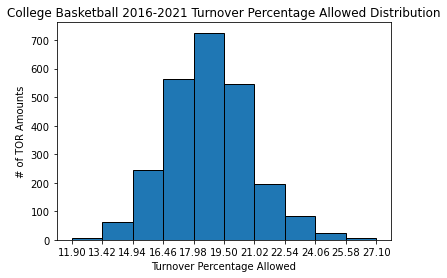

In [146]:
tor_col = games_played_cleaned.get_column("TOR")
fig, ax = plt.subplots()
tor_freqs, tor_cutoffs, tor_artists = plt.hist(tor_col, bins=10, edgecolor="black")
ax.set_xticks(tor_cutoffs)
plt.xlabel("Turnover Percentage Allowed")
plt.ylabel("# of TOR Amounts")
plt.title("College Basketball 2016-2021 Turnover Percentage Allowed Distribution")
plt.show()

## **Turnover Percentage and ADJOE Correlation**

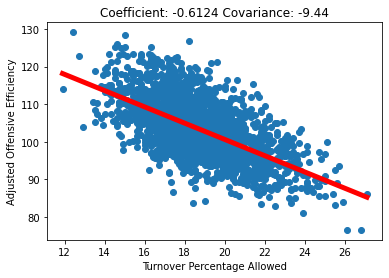

In [147]:
importlib.reload(myutils)
plt.scatter(tor_col, adjoe_col)

m, b = myutils.compute_slope_intercept(tor_col, adjoe_col)
plt.plot([min(tor_col), max(tor_col)], [m * min(tor_col) + b, m * max(tor_col) + b],
    c="red", lw=5)

r_val = myutils.compute_r(tor_col, adjoe_col)

covariance = myutils.compute_cov(tor_col, adjoe_col, r_val)
plt.title("Coefficient: {:.4f} Covariance: {:.2f}".format(r_val, covariance))
plt.ylabel("Adjusted Offensive Efficiency")
plt.xlabel("Turnover Percentage Allowed")
plt.show()

## **Offensive Rebounding Distribution**

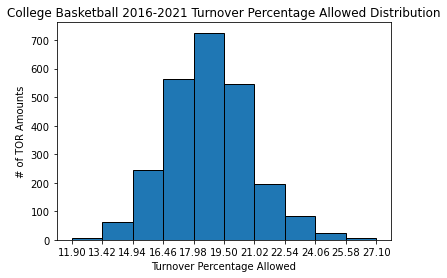

In [148]:
orb_col = games_played_cleaned.get_column("TOR")
orb_col.sort()
fig, ax = plt.subplots()
orb_freqs, orb_cutoffs, orb_artists = plt.hist(orb_col, bins=10, edgecolor="black")
ax.set_xticks(orb_cutoffs)
plt.xlabel("Turnover Percentage Allowed")
plt.ylabel("# of TOR Amounts")
plt.title("College Basketball 2016-2021 Turnover Percentage Allowed Distribution")
plt.show()

## **Insights**
As we can see, most of the distributions in our data were fairly symmetrical, with little data that was skewed. This ended up making the data very easy to predict with and give promising results we will see in the next part of this notebook. As for the correlation, there seems to be a small correlation between ADJOE and total wins. There likely would have been a stronger correlation had the ADJOE been correlated with a win percentage rather than a total wins attribute, but there is still some correlation there. Turnover rate and Total wins had a complete negative correlation. This makes sense because the more you turn over the ball, the more points you give up, leading to potentially more losses.

## **Classifier Performance**

#### **kNN Preliminary Results**

In [149]:
importlib.reload(myutils)
knn_clf = MyKNeighborsClassifier(3)
knn_folds = myevaluation.stratified_kfold_split(X, y, 10)
knn_true, knn_predicted = myutils.do_fold_predictions(X, y, knn_folds, knn_clf, "kNN")
myutils.measure_classifier_performance(knn_true, knn_predicted, "kNN Classifier", 1, ['TRUE', "FALSE"], "TRUE")
myutils.write_classifier_performance(knn_true, knn_predicted, "kNN Classifier", 1, ['TRUE', "FALSE"], "TRUE", outfile_name)

STEP 1: kNN Classifier
k=10 Stratified K-Fold Cross Validation
ACCURACY: 0.9279
ERROR RATE: 0.0721

PRECISION SCORE: 0.9401
RECALL SCORE: 0.9268
F1 SCORE: 0.9334

MATRIX:
[[1240, 98], [79, 1038]]


#### **Naive Bayes Preliminary Results**

In [150]:
importlib.reload(myutils)
X = [value[2:12] for value in games_played.data]
y = [value[-1] for value in games_played.data]
nb_clf = MyNaiveBayesClassifier()
nb_folds = myevaluation.stratified_kfold_split(X, y, 10)
nb_true, nb_predicted = myutils.do_fold_predictions(X, y, nb_folds, nb_clf, "Naive Bayes")
myutils.measure_classifier_performance(nb_true, nb_predicted, "Naive Bayes Classifier", 2, ['TRUE', "FALSE"], "TRUE")
myutils.write_classifier_performance(nb_true, nb_predicted, "Naive Bayes Classifier", 2, ['TRUE', "FALSE"], "TRUE", outfile_name)

STEP 2: Naive Bayes Classifier
k=10 Stratified K-Fold Cross Validation
ACCURACY: 0.7234
ERROR RATE: 0.2766

PRECISION SCORE: 0.6834
RECALL SCORE: 0.9178
F1 SCORE: 0.7834

MATRIX:
[[1228, 110], [569, 548]]


#### **Decision Tree Preliminary Results**

In [151]:
tree_clf = MyDecisionTreeClassifier()
tree_true, tree_predicted = myutils.cross_val_predict(X, y, 10, True, tree_clf)
myutils.measure_classifier_performance(tree_true, tree_predicted, "Decision Tree", 3, ['TRUE', "FALSE"], "TRUE")
myutils.write_classifier_performance(tree_true, tree_predicted, "Decision Tree", 3, ['TRUE', "FALSE"], "TRUE", outfile_name)

STEP 3: Decision Tree
k=10 Stratified K-Fold Cross Validation
ACCURACY: 0.9222
ERROR RATE: 0.0778

PRECISION SCORE: 0.9666
RECALL SCORE: 0.8879
F1 SCORE: 0.9256

MATRIX:
[[1188, 150], [41, 1076]]


#### **Random Forest**

In [152]:
random_forest = mysklearn.myclassifiers.MyRandomForestClassifier(20, 7, 4)
forest_true, forest_predicted = myutils.cross_val_predict(X, y, 10, True, random_forest)
myutils.measure_classifier_performance(forest_true, forest_predicted, "Random Forest", 4, ["TRUE", "FALSE"], "TRUE")
myutils.write_classifier_performance(forest_true, forest_predicted, "Random Forest", 4, ["TRUE", "FALSE"], "TRUE", outfile_name, True)

STEP 4: Random Forest
k=10 Stratified K-Fold Cross Validation
ACCURACY: 0.9365
ERROR RATE: 0.0635

PRECISION SCORE: 0.9876
RECALL SCORE: 0.8946
F1 SCORE: 0.9388

MATRIX:
[[1197, 141], [15, 1102]]


## **Classifier Result Analysis**

Overall, our classifiers proved to be very accurate! This makes a lot of since because all of our attritues, including our class label, are binary so there is not a lot of variability in that regard. Still, our results are quite impressive. Breaking it down by each classifier, our worst performing one had to be Naive Bayes, with a 72.34% accuracy rate and an F1 Score of 78.34%. While these results were not too bad, they simply didn't compare to our other classifiers' performances. The third best classifier was Decision tree, with a 92.22% accuracy rate and a 92.56% F1 Score. We were very surprised by this, because we would have thought decision tree would have been the second best, but kNN ended up barely topping decision tree with a 92.79% accuracy rate and a 93.34% F1 score. To no one's suprise, however, the best performing classifier was random forest. Because random forest is built on top of deicison tree, it is already going to be a better classifier than it. As per its specific performance, the random forest had an accuracy of 93.69% and an F1 Score of 93.94%. Overall, we were very surprised by how accurate our classifiers were. In the future, we would have liked to maybe cut down the attributes and see which ones correlated most with winning, but this project feels like a very solid start in some more exploratory data analysis that can be done.